# Applied Machine Learning - ESC-50 Environmental Sound Classification

## Executive Summary

This notebook works with the **ESC-50 environmental sound dataset**. We selected 10 different sound classes from 5 categories. The goal is to build a machine learning model that can identify what type of sound it hears based on audio features we extract from the recordings.

In [1]:
import pandas as pd
import numpy as np
import yaml as yml

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from scripts.feature_extraction import extract_features,get_feature_groups , get_feature_names
from scripts.data_utils import load_audio_data, build_feature_matrix, split_data, encode_labels
from scripts.supervised_models import get_param_grids, get_svm_param_grids, run_grid_search, find_best_combination
from scripts.configs import CATEGORIES, SELECTED_CLASSES , FINAL_TEST_FOLD
from scripts.performance import compute_summary, compute_tpr_fpr , get_top_n_models 
from scripts.visualizations import (
    plot_confusion_matrix, plot_coverage,
    plot_accuracy_auc_bars, plot_learning_curve_champion, plot_roc_curves,
    plot_per_class_f1, plot_tsne, plot_confusion_pairs,
    plot_computational_cost, plot_model_stability
)

### Research Questions

**Main Question:**
- Can we identify what made a sound just by analyzing the audio recording?

**Supporting Questions:**
- Which audio features work best for classifying sounds?
- Which machine learning models perform best on this task?
- What's the best balance between model speed, accuracy, and complexity?
- Are our models consistent across different data splits?

### Our Approach

1. **Extract Audio Features**: Get 116 different measurements from each sound recording (things like pitch, frequency, loudness patterns)
2. **Group Features**: Create 8 different feature groups to test which audio properties matter most
3. **Train Multiple Models**: Test SVM, Logistic Regression, Random Forest, and KNN algorithms
4. **Proper Validation**: Use the dataset's built-in fold structure to avoid data leakage
5. **Compare Results**: Analyze accuracy, confusion patterns, speed, and stability

## Experimental Setup at a Glance

| Aspect | Detail |
|--------|--------|
| Dataset | ESC-50, 10 sound classes (2 from each category) |
| Total Samples | 400 audio files (40 per class) |
| Features | 116 audio measurements organized into 8 groups |
| Models Tested | SVM, Logistic Regression, Random Forest, KNN |
| Validation Method | Train on folds 1-4, test on fold 5 |
| Evaluation Metrics | Accuracy, TPR, FPR, AUC, confusion matrices |

### Selected Sound Classes

| Category | Sound 1 | Sound 2 |
|----------|---------|---------|
| Animals | dog | rooster |
| Natural | thunderstorm | sea_waves |
| Human | snoring | sneezing |
| Interior | clock_alarm | vacuum_cleaner |
| Exterior | siren | helicopter |

In [2]:
with open("config.yml", "r") as f:
    config = yml.safe_load(f)

file_path = config["file_path"]
audio_path = config["audio_path"]

df = pd.read_csv(file_path)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Load and Filter Data

Keep only the 10 sound classes we selected (2 from each of the 5 categories).

In [3]:
categories = CATEGORIES
selected_classes = SELECTED_CLASSES
df_filtered = df[df['category'].isin(selected_classes)]

In [4]:
class_counts = df_filtered['category'].value_counts()
print("Class counts for selected categories:\n", class_counts)

Class counts for selected categories:
 category
dog               40
vacuum_cleaner    40
thunderstorm      40
clock_alarm       40
helicopter        40
snoring           40
sneezing          40
rooster           40
sea_waves         40
siren             40
Name: count, dtype: int64


In [5]:
category_to_target = df_filtered.set_index('category')['target'].to_dict()


mapping_df = pd.DataFrame(category_to_target.items(), columns=['Category', 'Target'])
print(mapping_df.to_string(index=False))

      Category  Target
           dog       0
vacuum_cleaner      36
  thunderstorm      19
   clock_alarm      37
    helicopter      40
       snoring      28
      sneezing      21
       rooster       1
     sea_waves      11
         siren      42


In [6]:
AUDIO_PATH = audio_path
DATA_PATH = file_path

In [7]:
audio_data = load_audio_data(df_filtered, audio_path)

Loaded 400 audio files.


In [8]:
X, y, filenames = build_feature_matrix(df_filtered, audio_path, extract_features)

Feature matrix shape: (400, 116)
Number of samples: 400
Number of features per sample: 116

Class distribution:
clock_alarm       40
dog               40
helicopter        40
rooster           40
sea_waves         40
siren             40
sneezing          40
snoring           40
thunderstorm      40
vacuum_cleaner    40
Name: count, dtype: int64


In [9]:
feature_names = get_feature_names()
print(f"Total features: {len(feature_names)}")

feature_groups = get_feature_groups(feature_names)

for group_name, indices in feature_groups.items():
    print(f"{group_name}: {len(indices)} features")

Total features: 116
temporal: 31 features
harmonic: 58 features
spectral_brightness: 61 features
noise_based: 11 features
general_set_1: 57 features
general_set_2: 65 features
last_set_chroma_tonnetz: 36 features
all_features: 116 features


## Feature Engineering

### Why Extract Features?

We can't feed raw audio directly to machine learning models. Instead, we extract **116 numerical features** that describe different aspects of each sound. Think of these as different ways to measure and describe audio.

### Feature Groups (8 Different Sets)

#### 1. **Temporal Features (31 features)**
These measure how the sound changes over time:
- **Delta MFCCs**: Track how the sound evolves
- **Zero Crossing Rate (ZCR)**: Distinguishes sharp sounds (like claps) from smooth ones
- **Envelope**: Measures how loud the sound gets over time
- **Example**: Helps tell a dog bark (short bursts) from a vacuum (continuous)

#### 2. **Harmonic Features (58 features)**
These measure the musical/tonal qualities:
- **MFCCs**: Capture the overall "color" or timbre of sound
- **Pitch**: How high or low the sound is
- **HNR (Harmonic-to-Noise Ratio)**: Is it musical/tonal or noisy?
- **Example**: Great for separating clean sounds (rooster, siren) from noisy ones (helicopter, vacuum)

#### 3. **Spectral Brightness Features (61 features)**
These measure the frequency distribution:
- **Spectral Centroid**: The "brightness" (high for sirens, low for thunder)
- **Spectral Contrast**: The difference between loud and quiet frequencies
- **Example**: Captures whether a sound has high or low frequencies

#### 4. **Noise-Based Features (11 features)**
These measure how "noisy" vs "pure" a sound is:
- **Spectral Flatness**: Is it random noise or a clear tone?
- **Example**: Separates white noise (vacuum) from musical tones (alarm)

#### 5. **Musical Features (36 features)**
These capture pitch and harmony:
- **Chroma**: Which musical notes are present
- **Tonnetz**: Harmonic relationships between notes
- **Example**: Useful for sounds with musical structure (sirens, alarms, animal calls)

#### 6. **Combined Sets**
- **general_set_1** & **general_set_2**: Mix of multiple feature types
- **all_features**: All 116 features together

### Why Test Multiple Feature Sets?

Different sounds need different features:
- **Tonal sounds** (rooster, siren) → Need pitch and harmonic features
- **Noisy sounds** (helicopter, vacuum) → Need noise-based features  
- **Time-varying sounds** (dog barks, sneezing) → Need temporal features

By testing 8 different feature combinations, we can find which audio properties are most important for identifying each sound type.

## Extract Features from Audio Files

This step processes all 400 audio files and extracts 116 features from each one.

In [10]:
# Save features to NPZ file for reproducibility
import os

# Create directory if it doesn't exist
os.makedirs('saved_data', exist_ok=True)

# Save features
np.savez(
    'saved_data/features_all_116.npz',
    X=X,
    y=y,
    filenames=filenames,
    feature_names=feature_names
)

print(f"Saved {X.shape[0]} samples with {X.shape[1]} features to saved_data/features_all_116.npz")
print(f"Label count: {len(y)}, Feature names: {len(feature_names)}")
print("Reload with: data = np.load('saved_data/features_all_116.npz', allow_pickle=True)")

Saved 400 samples with 116 features to saved_data/features_all_116.npz
Label count: 400, Feature names: 116
Reload with: data = np.load('saved_data/features_all_116.npz', allow_pickle=True)


### Saving Features

Extracting features from 400 audio files takes time. To avoid repeating this work, we save all the features to a file (.npz format). Next time, we can just load the saved features instead of recalculating everything.

In [11]:
y_encoded, le = encode_labels(y)
X_train, X_test, y_train, y_test, train_mask, test_mask = split_data(X, y_encoded, df_filtered, FINAL_TEST_FOLD)

Training set: 320 samples
Test set: 80 samples

Class distribution in train set:
0    32
1    32
2    32
3    32
4    32
5    32
6    32
7    32
8    32
9    32
Name: count, dtype: int64

Class distribution in test set:
0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
8    8
9    8
Name: count, dtype: int64


In [12]:
# Check fold 5 sample count
fold_5_count = (df_filtered['fold'] == 5).sum()
print(f"Fold 5 has {fold_5_count} samples")

# Or see all fold distributions
print("\nSamples per fold:")
print(df_filtered['fold'].value_counts().sort_index())

Fold 5 has 80 samples

Samples per fold:
fold
1    80
2    80
3    80
4    80
5    80
Name: count, dtype: int64


## Data Splitting Strategy

### Why Use Predefined Folds?

The ESC-50 dataset comes with **5 pre-organized folds**. This is important because:
- Multiple recordings might come from the same original source
- If we randomly split data, some related recordings might end up in both training and test sets
- This would make our model look better than it really is (called "data leakage")
- Using the predefined folds keeps related recordings together

### Our Splitting Approach

1. **Test Set (Fold 5)**: Set aside 80 samples (8 per class) for final testing
2. **Training Set (Folds 1-4)**: Use 320 samples (32 per class) for training
3. **Cross-Validation**: Within folds 1-4, take turns using different folds for validation
4. **Final Test**: Test on fold 5 only ONCE at the very end

### Why We Did : (our dataset already contains folds in order to prevents data leakage)

- Prevents "cheating" by keeping test data completely separate
- Matches the standard way researchers evaluate on ESC-50
- Allows fair comparison with published results
- More realistic estimate of real-world performance

### Note About K-means

We implemented unsupervised clustering (K-means) in a separate notebook to keep this notebook focused on supervised learning models.

In [13]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'degree': [2, 3, 4]  # Only used for poly kernel
}

In [14]:
print(f"Final test fold: {FINAL_TEST_FOLD}")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print("\nClass distribution in train set:")
print(pd.Series(y_train).value_counts().sort_index())

print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts().sort_index())

Final test fold: 5
Training set: 320 samples
Test set: 80 samples

Class distribution in train set:
0    32
1    32
2    32
3    32
4    32
5    32
6    32
7    32
8    32
9    32
Name: count, dtype: int64

Class distribution in test set:
0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
8    8
9    8
Name: count, dtype: int64


In [15]:
CV_FOLDS = [1, 2, 3, 4]

In [16]:
svm_param_grids = get_svm_param_grids()

In [17]:
svm_param_grids = {
    "linear": {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100]
    },
    "rbf": {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1, 'scale']
    },
    "poly": {
        'kernel': ['poly'],
        'C': [0.1, 1, 10],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }
}

## Part 1: Detailed SVM Analysis

First, we focus on SVM as our main model and thoroughly explore it across all feature groups with different kernels.

In [18]:
FINAL_TEST_FOLD = 5
train_mask = df_filtered['fold'] != FINAL_TEST_FOLD
test_mask = df_filtered['fold'] == FINAL_TEST_FOLD

X_train_all = X[train_mask]  # Folds 1-4
X_test_final = X[test_mask]  # Fold 5
y_train_all = y_encoded[train_mask]
y_test_final = y_encoded[test_mask]

# Get fold labels for CV (folds 1-4)
cv_folds = df_filtered.loc[train_mask, 'fold'].values

all_results = []

## Step 2: Train Models with Each Feature Group

For each of the 8 feature groups, we'll test different SVM configurations and find the best one.

In [19]:
for group_name, feature_indices in feature_groups.items():
    print(f"\n{'='*70}")
    print(f"Feature Group: {group_name} ({len(feature_indices)} features)")
    print(f"{'='*70}")
    
    X_train_group = X_train_all[:, feature_indices]
    X_test_group = X_test_final[:, feature_indices]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_group)
    X_test_scaled = scaler.transform(X_test_group)
    best_score = -1
    best_model = None
    best_params = None
    
    for kernel_name, param_grid in svm_param_grids.items():
        print(f"  Testing {kernel_name} kernel...")
        
        ps = PredefinedSplit(test_fold=cv_folds - 1)
        
        grid_search = GridSearchCV(
            SVC(random_state=42),
            param_grid,
            cv=ps,
            scoring='accuracy',
            n_jobs=-1
        )
        grid_search.fit(X_train_scaled, y_train_all)
        
        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test_final, y_pred)
    
    print(f"Best params: {best_params}")
    print(f"Best CV score (folds 1-4): {best_score:.4f}")
    print(f"Final test accuracy (fold 5): {test_acc:.4f}")
    
    all_results.append({
        'feature_group': group_name,
        'n_features': len(feature_indices),
        'best_params': best_params,
        'cv_score': best_score,
        'test_accuracy': test_acc,
        'model': best_model  
    })

    results_df = pd.DataFrame(all_results)


Feature Group: temporal (31 features)
  Testing linear kernel...
  Testing rbf kernel...
  Testing poly kernel...
Best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV score (folds 1-4): 0.7188
Final test accuracy (fold 5): 0.7375

Feature Group: harmonic (58 features)
  Testing linear kernel...
  Testing rbf kernel...
  Testing poly kernel...
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score (folds 1-4): 0.8406
Final test accuracy (fold 5): 0.8875

Feature Group: spectral_brightness (61 features)
  Testing linear kernel...
  Testing rbf kernel...
  Testing poly kernel...
Best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV score (folds 1-4): 0.8500
Final test accuracy (fold 5): 0.8750

Feature Group: noise_based (11 features)
  Testing linear kernel...
  Testing rbf kernel...
  Testing poly kernel...
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV score (folds 1-4): 0.6656
Final test accuracy (fold 5): 0.6750

Feature Group: gene

## Model Training and Finding Best Settings

### Our Strategy

We use a **systematic search** to find the best model and settings:

1. **For Each Feature Set** (8 total):
   - Test multiple model types (SVM, Logistic Regression, Random Forest, KNN)
   - Try many different settings for each model
   - Use cross-validation to see which settings work best
   - Keep track of the best performers

2. **SVM Settings We Tested**:
   - **Kernel types**: linear, RBF, polynomial
   - **C (controls overfitting)**: [0.1, 1, 10, 100]
   - **Gamma (for RBF kernel)**: [0.001, 0.01, 0.1, 'scale']
   - **Degree (for polynomial)**: [2, 3, 4]

3. **Validation Process**:
   - Train on folds 1-4 (320 samples)
   - Test different combinations within training data
   - Pick the best settings based on accuracy
   - **Test on fold 5 only ONCE** (80 samples) after choosing the winner


In [20]:
results_df.sort_values("test_accuracy", ascending=False).head(10)


,feature_group,n_features,best_params,cv_score,test_accuracy,model
1,harmonic,58,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.840625,0.8875,"SVC(C=10, random_state=42)"
2,spectral_brightness,61,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.850000,0.8750,"SVC(C=10, gamma=0.01, random_state=42)"
5,general_set_2,65,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.859375,0.8750,"SVC(C=10, gamma=0.01, random_state=42)"
7,all_features,116,"{'C': 0.1, 'kernel': 'linear'}",0.878125,0.8500,"SVC(C=0.1, kernel='linear', random_state=42)"
4,general_set_1,57,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.828125,0.8125,"SVC(C=10, gamma=0.01, random_state=42)"
0,temporal,31,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.718750,0.7375,"SVC(C=10, gamma=0.01, random_state=42)"
3,noise_based,11,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.665625,0.6750,"SVC(C=10, gamma=0.1, random_state=42)"
6,last_set_chroma_tonnetz,36,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.612500,0.5625,"SVC(C=1, random_state=42)"


In [21]:
summary_df = (
    results_df
    .groupby("feature_group")
    .agg(
        mean_test_accuracy=("test_accuracy", "mean"),
        n_features=("n_features", "first")
    )
    .sort_values("mean_test_accuracy", ascending=False)
)

print(summary_df)

                         mean_test_accuracy  n_features
feature_group                                          
harmonic                             0.8875          58
general_set_2                        0.8750          65
spectral_brightness                  0.8750          61
all_features                         0.8500         116
general_set_1                        0.8125          57
temporal                             0.7375          31
noise_based                          0.6750          11
last_set_chroma_tonnetz              0.5625          36


In [22]:
FINAL_CONFIG = {
    'feature_group': 'general_set_2',
    'kernel': 'rbf',
    'C': 10,
    'gamma': 0.001
}

**We didn't assume RBF was better, we tested all three kernels (linear, RBF, polynomial) using GridSearchCV. RBF won in 7 out of 8 feature groups because environmental sound classes have non-linear boundaries in feature space. Linear only won when using all 116 features, where high dimensionality makes data more linearly separable.**

In [23]:
feature_indices = feature_groups['general_set_2']

# Select features

In [56]:
X_all_selected = X[:, feature_indices]

# Scale
final_scaler = StandardScaler()
X_all_scaled = final_scaler.fit_transform(X_all_selected)

# Train
final_model = SVC(
    kernel=FINAL_CONFIG['kernel'],
    C=FINAL_CONFIG['C'],
    gamma=FINAL_CONFIG['gamma'],
    random_state=42
)

final_model.fit(X_all_scaled, y_encoded)

print(f"\nFinal model trained on all {X_all_scaled.shape[0]} samples")
print(f"Using {X_all_scaled.shape[1]} general_set_2 features")


Final model trained on all 400 samples
Using 65 general_set_2 features


In [25]:
svm_feature_indices = feature_groups['general_set_2']

# Best hyperparameters from GridSearch
svm_best_params = {
    'kernel': 'rbf',
    'C': 10,
    'gamma': 0.001
}

print(f"\nUsing {len(svm_feature_indices)} general_set_2 features")
print(f"Hyperparameters: {svm_best_params}\n")

FINAL_TEST_FOLD = 5

train_mask = df_filtered['fold'] != FINAL_TEST_FOLD
test_mask = df_filtered['fold'] == FINAL_TEST_FOLD

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y_encoded[train_mask]
y_test = y_encoded[test_mask]

print(f"Training on folds: 1, 2, 3, 4")
print(f"Testing on fold: {FINAL_TEST_FOLD}")

# Select features
svm_X_train_selected = X_train[:, svm_feature_indices]
svm_X_test_selected = X_test[:, svm_feature_indices]

# Scale
svm_scaler = StandardScaler()
svm_X_train_scaled = svm_scaler.fit_transform(svm_X_train_selected)
svm_X_test_scaled = svm_scaler.transform(svm_X_test_selected)

print(f"\nTraining set: {svm_X_train_scaled.shape}")
print(f"Test set: {svm_X_test_scaled.shape}")


svm_model = SVC(
    kernel=svm_best_params['kernel'],
    C=svm_best_params['C'],
    gamma=svm_best_params['gamma'],
    probability=True,
    random_state=42
)

svm_model.fit(svm_X_train_scaled, y_train)

print(f"SVM FINAL TEST RESULTS (Fold {FINAL_TEST_FOLD})")

# Training accuracy
svm_y_train_pred = svm_model.predict(svm_X_train_scaled)
svm_train_accuracy = accuracy_score(y_train, svm_y_train_pred)

# Test accuracy
svm_y_pred = svm_model.predict(svm_X_test_scaled)
svm_y_pred_proba = svm_model.predict_proba(svm_X_test_scaled)
svm_test_accuracy = accuracy_score(y_test, svm_y_pred)

print(f"\nTraining Accuracy: {svm_train_accuracy:.4f} ({svm_train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy*100:.2f}%)")
print(f"Overfitting Gap: {(svm_train_accuracy - svm_test_accuracy)*100:.2f}%\n")


Using 65 general_set_2 features
Hyperparameters: {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}

Training on folds: 1, 2, 3, 4
Testing on fold: 5

Training set: (320, 65)
Test set: (80, 65)
SVM FINAL TEST RESULTS (Fold 5)

Training Accuracy: 0.9625 (96.25%)
Test Accuracy: 0.8750 (87.50%)
Overfitting Gap: 8.75%



In [26]:
print("Classification Report:")
print(classification_report(y_test, svm_y_pred, target_names=le.classes_))

Classification Report:
                precision    recall  f1-score   support

   clock_alarm       1.00      1.00      1.00         8
           dog       0.88      0.88      0.88         8
    helicopter       0.70      0.88      0.78         8
       rooster       1.00      1.00      1.00         8
     sea_waves       1.00      0.88      0.93         8
         siren       1.00      0.75      0.86         8
      sneezing       0.67      1.00      0.80         8
       snoring       0.83      0.62      0.71         8
  thunderstorm       0.88      0.88      0.88         8
vacuum_cleaner       1.00      0.88      0.93         8

      accuracy                           0.88        80
     macro avg       0.89      0.88      0.88        80
  weighted avg       0.89      0.88      0.88        80



In [27]:
print("Train folds:", df_filtered.loc[train_mask, 'fold'].unique())
print("Test folds:", df_filtered.loc[test_mask, 'fold'].unique())


Train folds: [1 2 3 4]
Test folds: [5]


In [28]:
svm_y_train_pred = svm_model.predict(svm_X_train_scaled)  # Changed both variables
svm_train_accuracy = accuracy_score(y_train, svm_y_train_pred)

print(f"Training Accuracy: {svm_train_accuracy:.4f} ({svm_train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy*100:.2f}%)")


Training Accuracy: 0.9625 (96.25%)
Test Accuracy: 0.8750 (87.50%)


In [29]:
print(f"Gap:                {svm_train_accuracy-svm_test_accuracy:.4f}") 

Gap:                0.0875


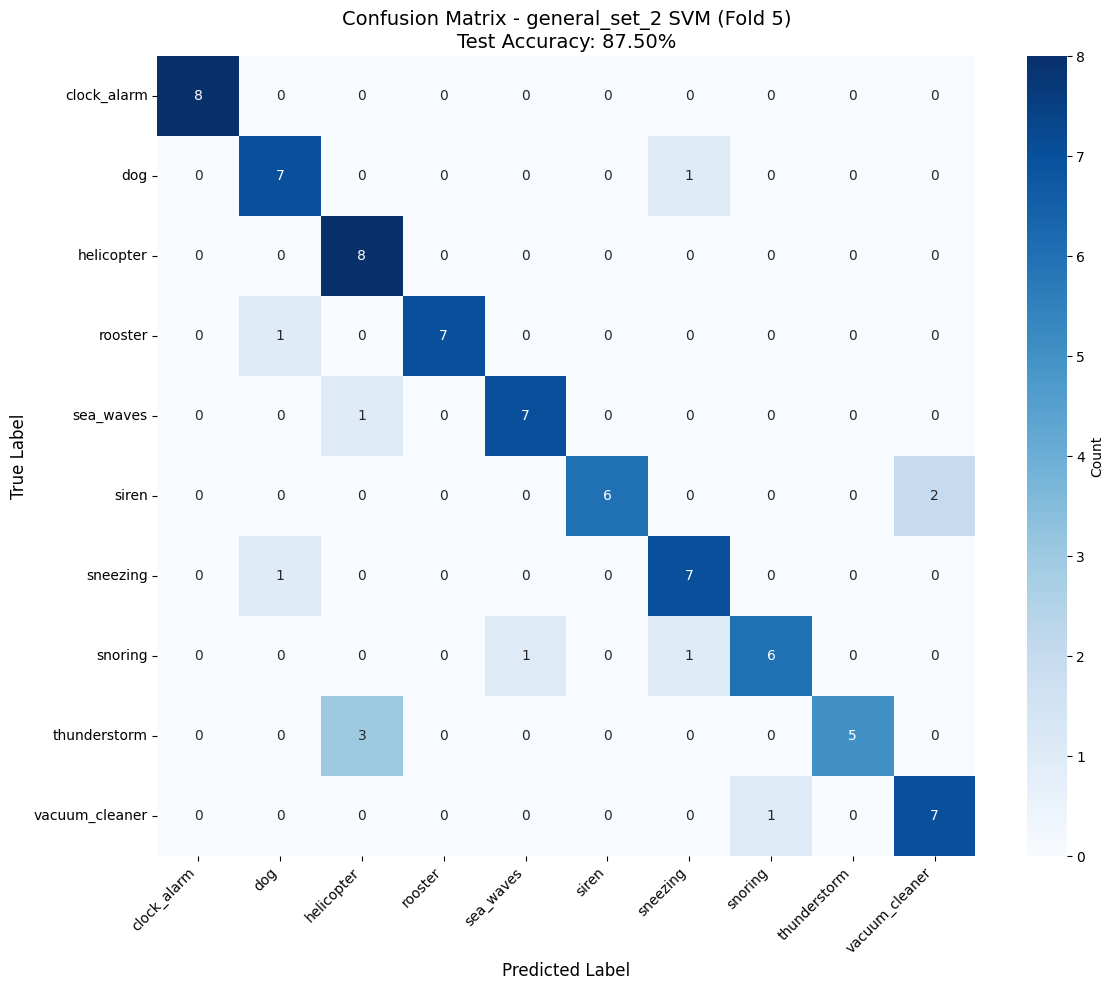

In [30]:
plot_confusion_matrix(
    y_test, y_pred, le.classes_,
    title=f"Confusion Matrix - general_set_2 SVM (Fold {FINAL_TEST_FOLD})",
    accuracy=svm_test_accuracy
)

In [31]:
# Hold out fold 5 as final test set
FINAL_TEST_FOLD = 5
train_val_mask = df_filtered['fold'] != FINAL_TEST_FOLD

X_all = X[train_val_mask][:, svm_feature_indices]
y_all = y_encoded[train_val_mask]
df_cv = df_filtered[train_val_mask].copy()

train_sizes = np.linspace(0.2, 1.0, 5)  # 20% → 100%

train_scores = []
val_scores = []

for frac in train_sizes:
    fold_train_scores = []
    fold_val_scores = []

    for test_fold in range(1, 5):
        train_mask = df_cv['fold'] != test_fold
        val_mask = df_cv['fold'] == test_fold

        X_train_full = X_all[train_mask]
        y_train_full = y_all[train_mask]

        X_val = X_all[val_mask]
        y_val = y_all[val_mask]

        n_train = int(len(X_train_full) * frac)
        X_train_sub = X_train_full[:n_train]
        y_train_sub = y_train_full[:n_train]

        # Scale per fold
        scaler = StandardScaler()
        X_train_sub = scaler.fit_transform(X_train_sub)
        X_val = scaler.transform(X_val)

        model = SVC(
            kernel='rbf',
            C=10,
            gamma=0.001
        )

        model.fit(X_train_sub, y_train_sub)

        fold_train_scores.append(
            accuracy_score(y_train_sub, model.predict(X_train_sub))
        )
        fold_val_scores.append(
            accuracy_score(y_val, model.predict(X_val))
        )

    train_scores.append(np.mean(fold_train_scores))
    val_scores.append(np.mean(fold_val_scores))

In [32]:
print(val_scores)

[np.float64(0.60625), np.float64(0.73125), np.float64(0.7625), np.float64(0.828125), np.float64(0.84375)]


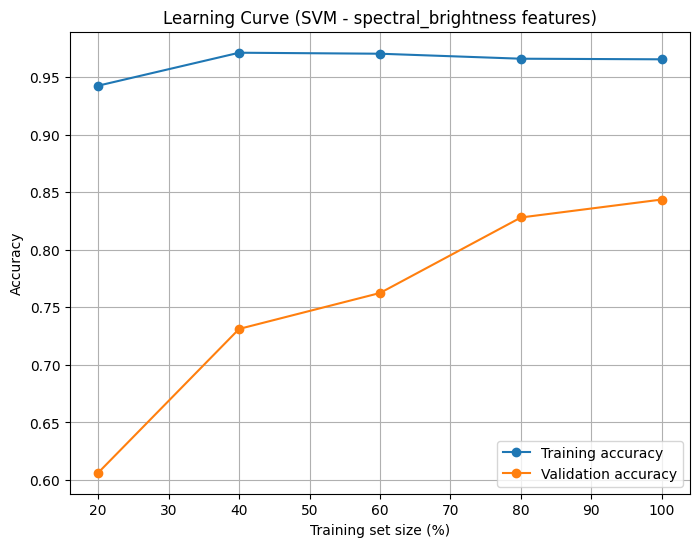

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * 100, train_scores, 'o-', label="Training accuracy")
plt.plot(train_sizes * 100, val_scores, 'o-', label="Validation accuracy")
plt.xlabel("Training set size (%)")
plt.ylabel("Accuracy")
plt.title("Learning Curve (SVM - spectral_brightness features)")
plt.legend()
plt.grid(True)
plt.show()

## Part 2: Model Comparison

Now we compare SVM against other algorithms (Logistic Regression, Random Forest, KNN) across all feature groups.

**Note:** This grid search does not include SVM again to ensure fair comparison with other models, because we already implemneted our model wit. hyperparameter tuning.

param_grids = get_param_grids()
grid_search_all_results = run_grid_search(X, y_encoded, df_filtered, feature_groups, param_grids, FINAL_TEST_FOLD)

In [34]:
param_grids = get_param_grids()
grid_search_all_results = run_grid_search(X, y_encoded, df_filtered, feature_groups, param_grids, FINAL_TEST_FOLD)


FEATURE GROUP: temporal (31 features)

------------------------------------------------------------
Model: Logistic Regression
------------------------------------------------------------
Best Parameters: {'C': 0.1, 'l1_ratio': 0.0}
Best CV Score: 0.6906
Test Accuracy: 0.7000

------------------------------------------------------------
Model: Random Forest
------------------------------------------------------------
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score: 0.7406
Test Accuracy: 0.7625

------------------------------------------------------------
Model: KNN
------------------------------------------------------------
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Best CV Score: 0.6000
Test Accuracy: 0.5500

FEATURE GROUP: harmonic (58 features)

------------------------------------------------------------
Model: Logistic Regression
------------------------------------------------------------
Best

In [35]:
svm_y_pred_proba = svm_model.predict_proba(svm_X_test_scaled)  

svm_result = {
    'best_model': svm_model,
    'best_params': svm_best_params,
    'best_cv_score': 0.8594,
    'test_accuracy': svm_test_accuracy,
    'y_pred': svm_y_pred,
    'y_pred_proba': svm_y_pred_proba,  
    'feature_indices': svm_feature_indices,
    'n_features': len(svm_feature_indices),
    'scaler': svm_scaler
}

if 'general_set_2' not in grid_search_all_results:
    grid_search_all_results['general_set_2'] = {}

# Add SVM to the results
grid_search_all_results['general_set_2']['SVM'] = svm_result

print("SVM (general_set_2) added to comparison results")
print(f"   Test Accuracy: {svm_test_accuracy:.4f}")
print(f"   Features: {len(svm_feature_indices)}")


SVM (general_set_2) added to comparison results
   Test Accuracy: 0.8750
   Features: 65


# Logistic Regression

In [36]:
lr_feature_group_name = 'harmonic'
lr_feature_indices = feature_groups[lr_feature_group_name]

# RECREATE masks to ensure they're fresh and match X
FINAL_TEST_FOLD = 5
train_mask = df_filtered['fold'] != FINAL_TEST_FOLD  # Recreate fresh mask
test_mask = df_filtered['fold'] == FINAL_TEST_FOLD   # Recreate fresh mask

# Split data
X_train = X[train_mask][:, lr_feature_indices]
X_test = X[test_mask][:, lr_feature_indices]
y_train = y_encoded[train_mask]
y_test = y_encoded[test_mask]

lr_scaler = StandardScaler()
lr_X_train_scaled = lr_scaler.fit_transform(X_train)
lr_X_test_scaled = lr_scaler.transform(X_test)

print(f"Feature Group: {lr_feature_group_name}")
print(f"Number of Features: {len(lr_feature_indices)}")
print(f"Training set: {lr_X_train_scaled.shape}")
print(f"Test set: {lr_X_test_scaled.shape}")

# Train Logistic Regression
lr_model = LogisticRegression(
    C=0.1,
    l1_ratio=0.0, 
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
)

lr_model.fit(lr_X_train_scaled, y_train)

# Predictions
lr_y_train_pred = lr_model.predict(lr_X_train_scaled)
lr_y_pred = lr_model.predict(lr_X_test_scaled)
lr_y_pred_proba = lr_model.predict_proba(lr_X_test_scaled)

# Accuracies
lr_train_accuracy = accuracy_score(y_train, lr_y_train_pred)
lr_test_accuracy = accuracy_score(y_test, lr_y_pred)

print(f"\nLogistic Regression Results (C=0.1):")
print(f"Test Accuracy: {lr_test_accuracy:.4f} ({lr_test_accuracy*100:.2f}%)")


Feature Group: harmonic
Number of Features: 58
Training set: (320, 58)
Test set: (80, 58)

Logistic Regression Results (C=0.1):
Test Accuracy: 0.8750 (87.50%)


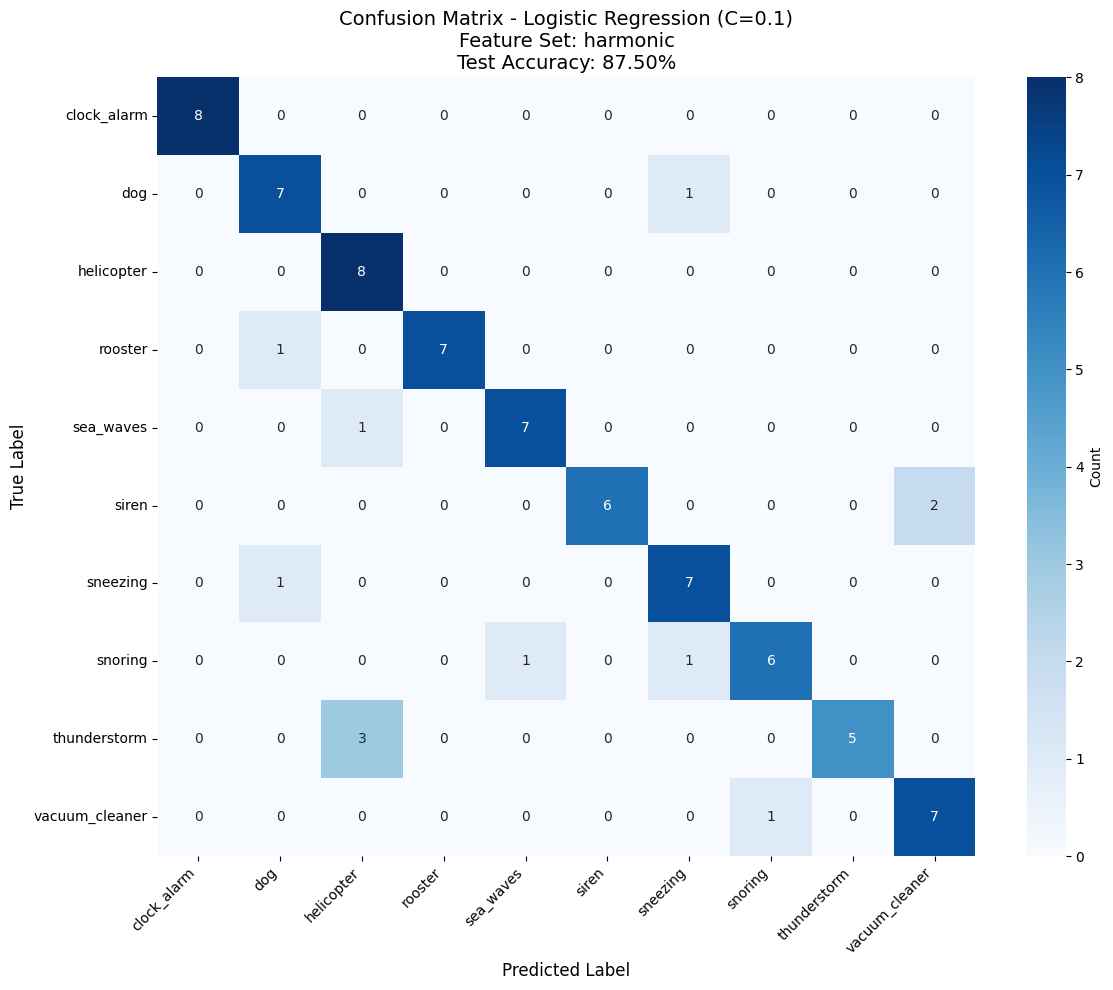

In [37]:
plot_confusion_matrix(
    y_test, 
    y_pred, 
    le.classes_,
    title=f'Confusion Matrix - Logistic Regression (C=0.1)\nFeature Set: {lr_feature_group_name}',
    accuracy=lr_test_accuracy
)

In [38]:
logistic_config = {
    'best_model': model,
    'feature_indices': feature_indices,
    'scaler': scaler
}

logistic_combination = {
    'model': 'Logistic Regression (C=0.1)',
    'group': lr_feature_group_name,
    'test_accuracy': lr_test_accuracy
}

# Get X_train from the split
train_mask = df_filtered['fold'] != 5
X_train = X[train_mask]

# Plot learning curve

Generating Learning Curve for: Logistic Regression (C=0.1)


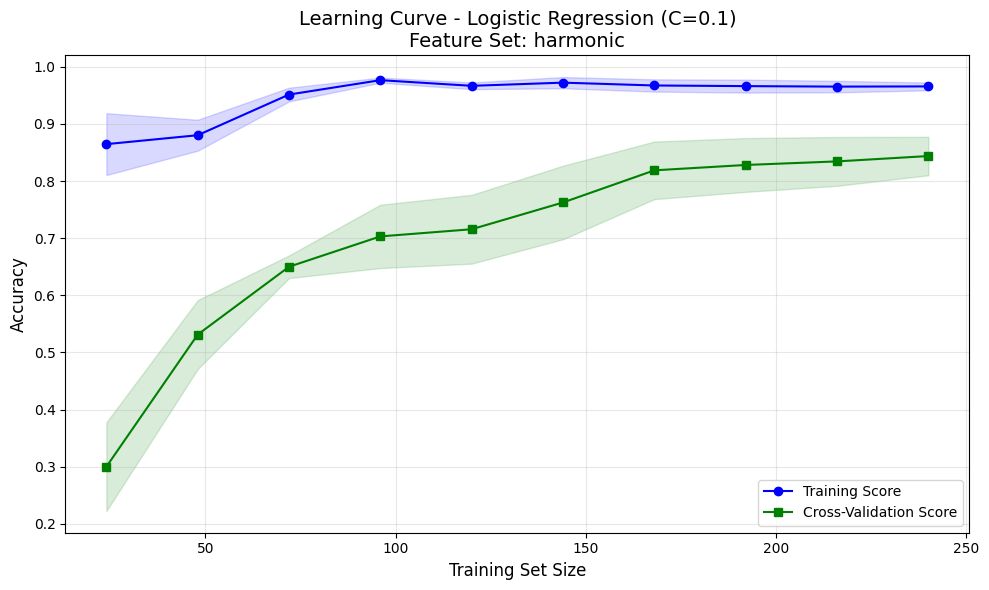

In [39]:
plot_learning_curve_champion(
    best_model_config=logistic_config,
    best_combination=logistic_combination,
    X_train=X_train,
    y_train=y_train,
    df_filtered=df_filtered,
    test_fold=5
)

In [40]:
print(f"Training Accuracy: {lr_train_accuracy:.4f} ({lr_train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {lr_test_accuracy:.4f} ({lr_test_accuracy*100:.2f}%)")
print(f"        Gap: {(lr_train_accuracy - lr_test_accuracy)*100:.2f}%")

Training Accuracy: 0.9656 (96.56%)
Test Accuracy: 0.8750 (87.50%)
        Gap: 9.06%


In [41]:
print("Classification Report:")
print(classification_report(y_test, lr_y_pred, target_names=le.classes_))

Classification Report:
                precision    recall  f1-score   support

   clock_alarm       1.00      0.88      0.93         8
           dog       0.88      0.88      0.88         8
    helicopter       0.73      1.00      0.84         8
       rooster       1.00      1.00      1.00         8
     sea_waves       1.00      0.88      0.93         8
         siren       1.00      0.88      0.93         8
      sneezing       0.67      1.00      0.80         8
       snoring       0.83      0.62      0.71         8
  thunderstorm       1.00      0.75      0.86         8
vacuum_cleaner       0.88      0.88      0.88         8

      accuracy                           0.88        80
     macro avg       0.90      0.88      0.88        80
  weighted avg       0.90      0.88      0.88        80



In [42]:
FINAL_TEST_FOLD = 5
train_mask = df_filtered['fold'] != FINAL_TEST_FOLD
test_mask = df_filtered['fold'] == FINAL_TEST_FOLD

X_train = X[train_mask] 
X_test = X[test_mask]   
y_train = y_encoded[train_mask]
y_test = y_encoded[test_mask]

print(f" Recreated X_train: {X_train.shape}")
print(f" Recreated X_test: {X_test.shape}")

 Recreated X_train: (320, 116)
 Recreated X_test: (80, 116)


## The best model


In [43]:
best_combination = find_best_combination(grid_search_all_results)

best_result_data = grid_search_all_results[best_combination['group']][best_combination['model']]

best_model = best_result_data['best_model']
best_feature_indices = best_result_data['feature_indices']

scaler = best_result_data['scaler']
X_test_group = X_test[:, best_feature_indices]
X_test_scaled = scaler.transform(X_test_group)
y_pred_best = best_model.predict(X_test_scaled)

print(f"Model: {best_combination['model']}")
print(f"Feature Group: {best_combination['group']}")
print(f"Test Accuracy: {best_combination['test_acc']:.4f}")
print(f"Number of Features: {best_combination['n_features']}")

Best combination overall:
Feature Group:      harmonic
Model:              Logistic Regression
Number of Features: 58
CV Score:           0.8281
Test Accuracy:      0.8750

Best Parameters:
{'C': 0.1, 'l1_ratio': 0.0}
Model: Logistic Regression
Feature Group: harmonic
Test Accuracy: 0.8750
Number of Features: 58


# Create results summary

**Note:** We filtered out Random Forest because it showed inflated train scores (100%) that didn't translate to better performance ,it still achieved 88.75% which is slightly than other models. Since RF offered more prone to overfitting on smaller feature sets , we focused our analysis on the simpler, equally effective models (Logistic Regression and SVM).


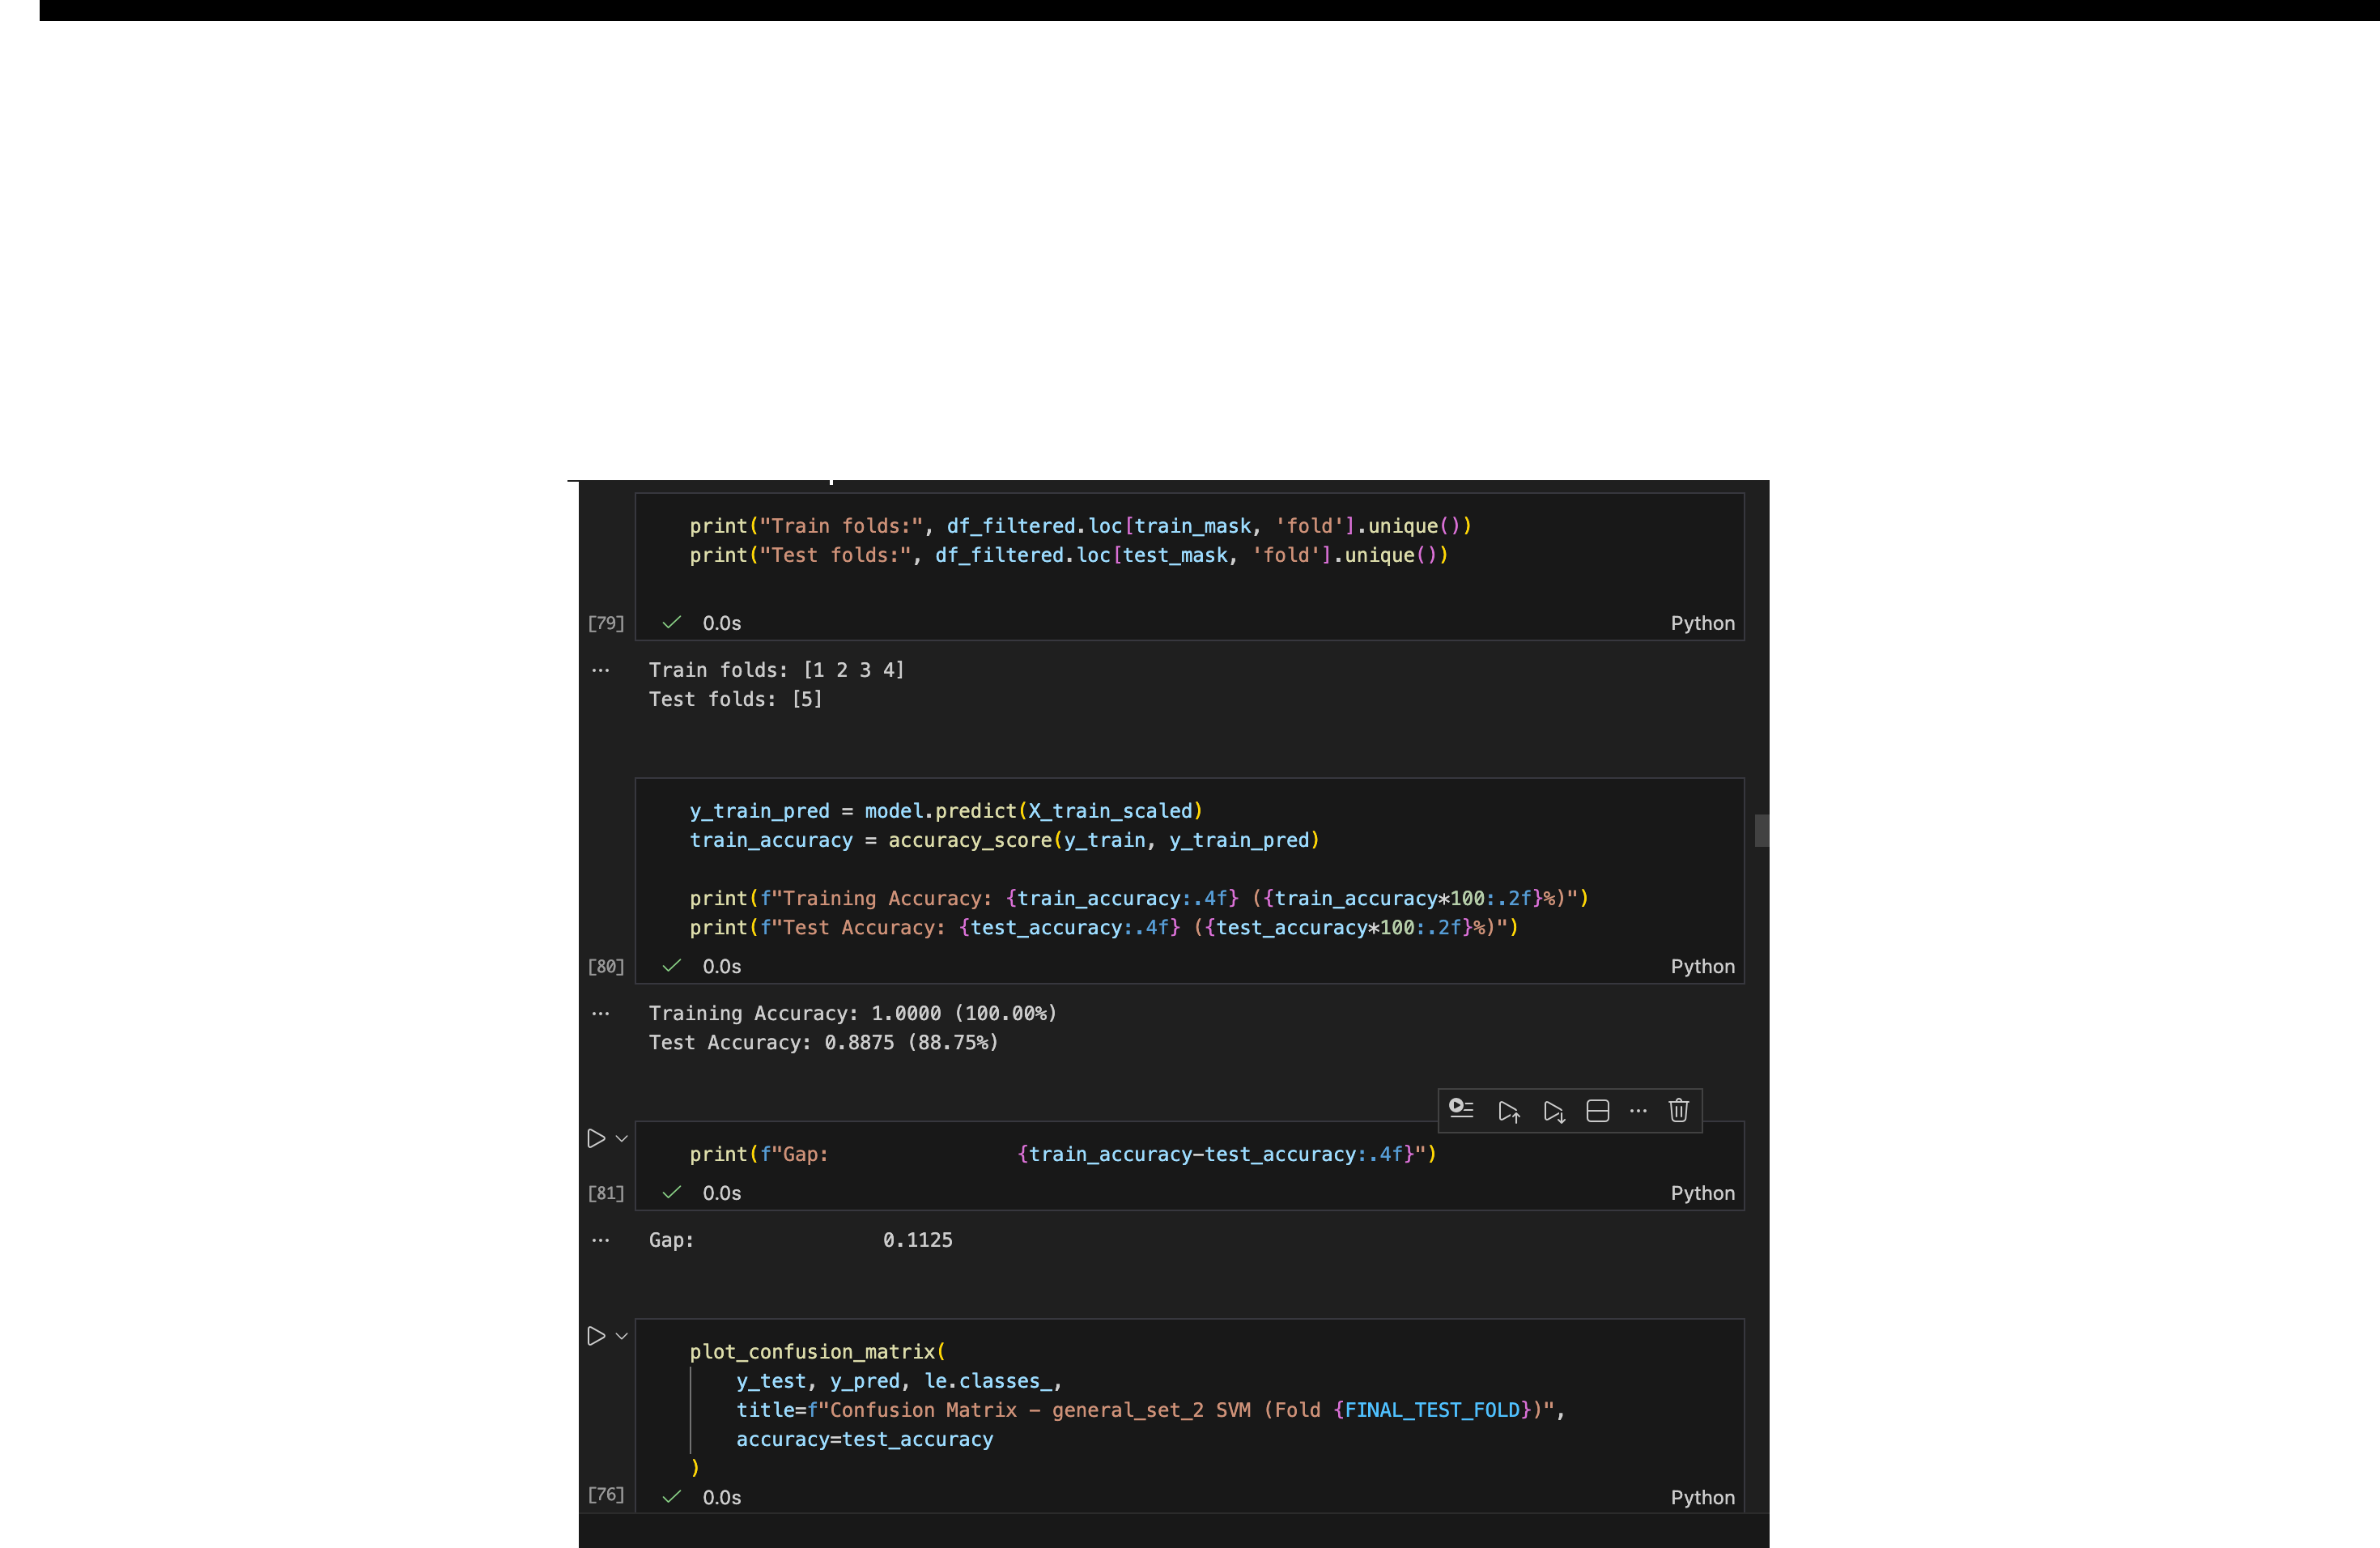

In [44]:
results_df = compute_summary(grid_search_all_results, y_test, le.classes_)

# Filter Random Forest from results_df
results_df = results_df[results_df['Model'] != 'Random Forest'].reset_index(drop=True)

for group_name in list(grid_search_all_results.keys()):
    if 'Random Forest' in grid_search_all_results[group_name]:
        del grid_search_all_results[group_name]['Random Forest']

print("\n" + "="*80)
print("ALL MODELS RANKED BY TEST ACCURACY (Random Forest excluded)")
print("="*80)
print(results_df.head(15).to_string(index=False, float_format="%.4f"))



ALL MODELS RANKED BY TEST ACCURACY (Random Forest excluded)
      Feature Group               Model  CV Accuracy  Test Accuracy  AUC Score  Overfitting
           harmonic Logistic Regression       0.8281         0.8750     0.9788      -0.0469
      general_set_2                 SVM       0.8594         0.8750     0.9859      -0.0156
       all_features Logistic Regression       0.8719         0.8500     0.9812       0.0219
spectral_brightness Logistic Regression       0.8375         0.8500     0.9799      -0.0125
      general_set_1 Logistic Regression       0.7937         0.8250     0.9682      -0.0312
      general_set_2 Logistic Regression       0.8656         0.8125     0.9792       0.0531
       all_features                 KNN       0.7531         0.7875     0.9672      -0.0344
      general_set_2                 KNN       0.7719         0.7750     0.9340      -0.0031
           harmonic                 KNN       0.7313         0.7500     0.9514      -0.0187
      general_set_1

## top 5 models at a glance

In [45]:
top_models = get_top_n_models(grid_search_all_results, n=5)

print("Top 5 Models:")
print("-" * 70)
for i, item in enumerate(top_models, 1):
    print(f"  {i}. {item['model']} + {item['group']} → {item['test_accuracy']:.4f}")


Top 5 Models:
----------------------------------------------------------------------
  1. Logistic Regression + harmonic → 0.8750
  2. SVM + general_set_2 → 0.8750
  3. Logistic Regression + spectral_brightness → 0.8500
  4. Logistic Regression + all_features → 0.8500
  5. Logistic Regression + general_set_1 → 0.8250


In [46]:
metrics_tpr_fpr_df = compute_tpr_fpr(grid_search_all_results, y_test, results_df)


SENSITIVITY AND FALSE ALARM ANALYSIS
              Model       Feature Group  Accuracy  TPR (macro)  FPR (macro)    AUC
Logistic Regression            harmonic    0.8750       0.8750       0.0139 0.9788
                SVM       general_set_2    0.8750       0.8750       0.0139 0.9859
Logistic Regression        all_features    0.8500       0.8500       0.0167 0.9812
Logistic Regression spectral_brightness    0.8500       0.8500       0.0167 0.9799
Logistic Regression       general_set_1    0.8250       0.8250       0.0194 0.9682
Logistic Regression       general_set_2    0.8125       0.8125       0.0208 0.9792
                KNN        all_features    0.7875       0.7875       0.0236 0.9672
                KNN       general_set_2    0.7750       0.7750       0.0250 0.9340
                KNN            harmonic    0.7500       0.7500       0.0278 0.9514
                KNN       general_set_1    0.7375       0.7375       0.0292 0.9368

TPR = sensitivity (fraction of positives correct

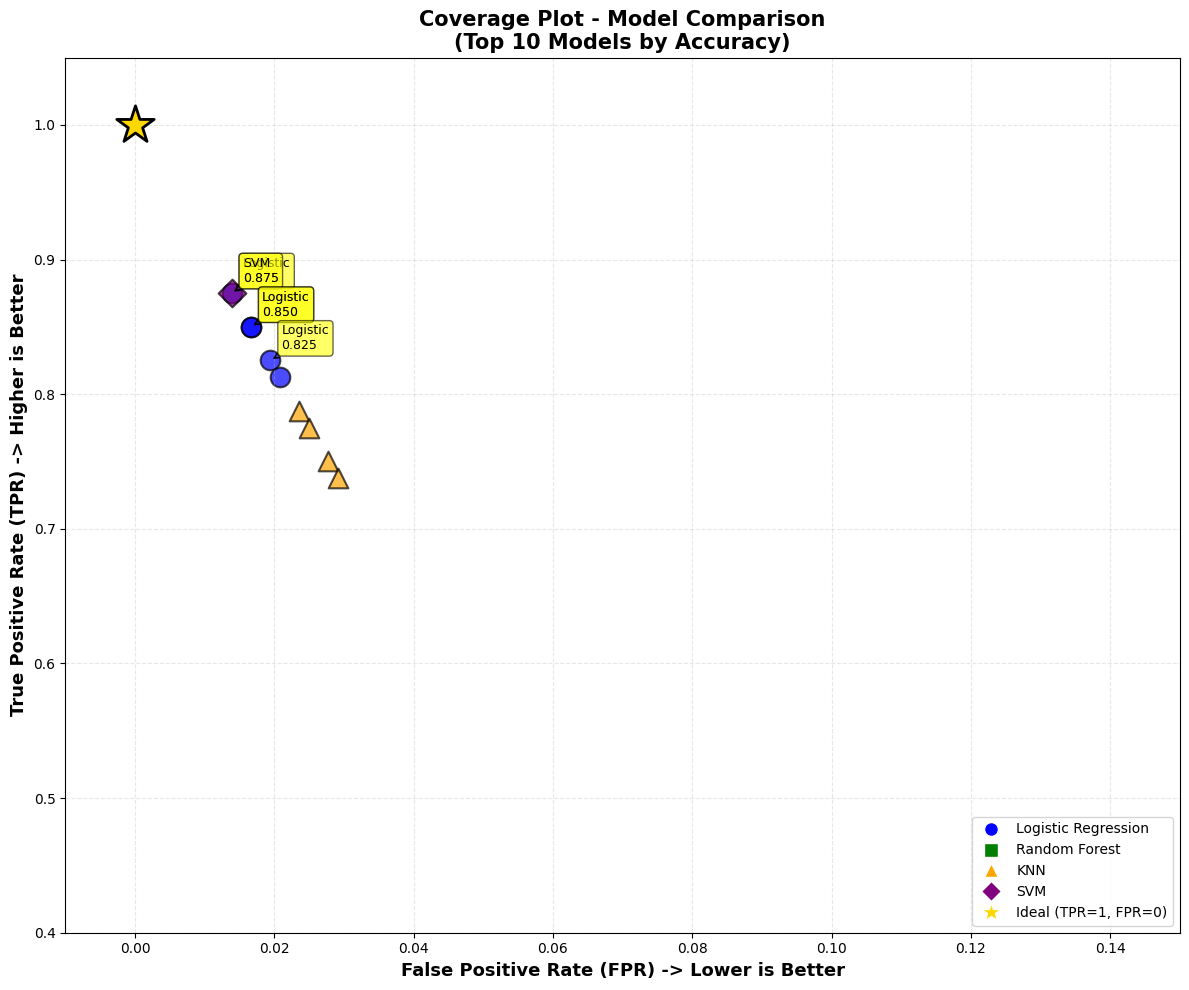


Reading the coverage plot:
  Points near the top-left corner have high sensitivity with few false alarms.
  The gold star marks the theoretical perfect classifier.
  Best model: Logistic Regression on harmonic -- TPR=0.875, FPR=0.014


In [47]:
plot_coverage(metrics_tpr_fpr_df, top_n=10)

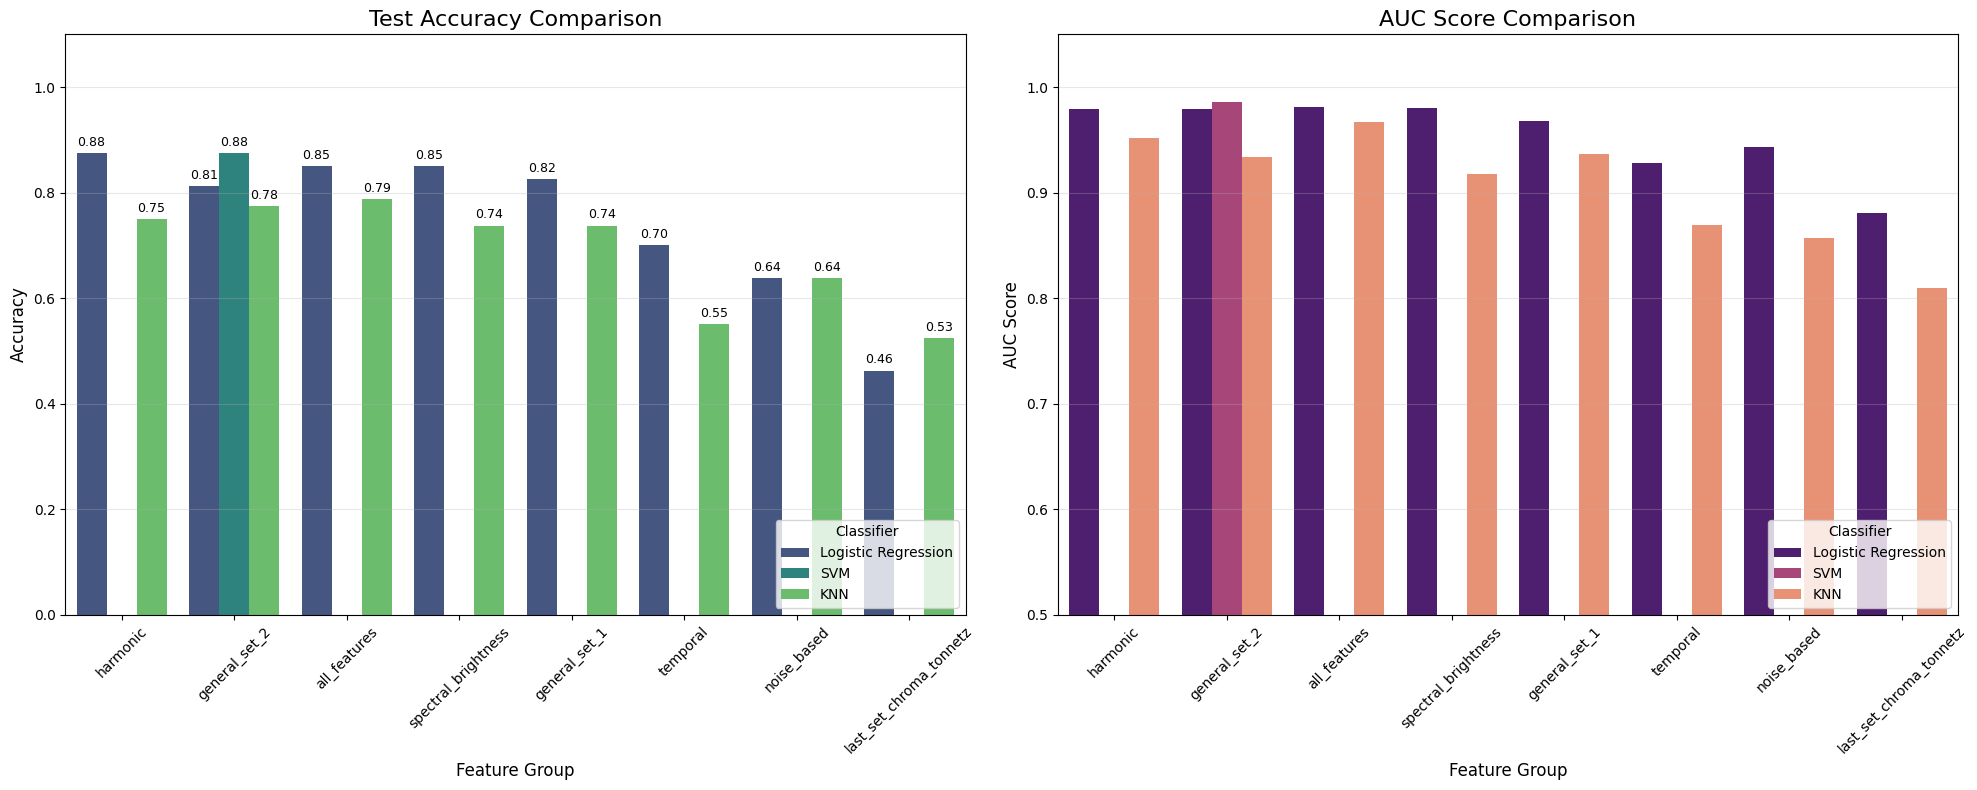

In [48]:
plot_accuracy_auc_bars(results_df)

In [49]:
print(f"Automatically selected Best Group: {best_combination['group']}")
print("Number of features: 58")

Automatically selected Best Group: harmonic
Number of features: 58


## Coverage Plot

This scatter plot shows each model's performance in two dimensions:
- **TPR (True Positive Rate)**: How good is the model at correctly identifying sounds?
- **FPR (False Positive Rate)**: How often does the model make false alarms?

Models in the **top-left corner** are best: they catch most real sounds (high TPR) while avoiding false alarms (low FPR). This is ideal for a monitoring system.

## Sensitivity and False Alarm Rates

Beyond simple accuracy, we look at two important metrics:
- **TPR (Sensitivity)**: Out of all real sounds, what percentage did we correctly detect?
- **FPR (False Alarm Rate)**: Out of all non-target sounds, what percentage did we wrongly flag?

These metrics tell us how well each model balances catching real events versus avoiding false alarms.

## ROC Curves: Comparing Multiple Models

ROC curves show how well each model distinguishes between different sound classes.

Plotting ROC for the Top 5 Models:
 -> Logistic Regression (harmonic) (Acc: 87.50%)
 -> SVM (general_set_2) (Acc: 87.50%)
 -> Logistic Regression (spectral_brightness) (Acc: 85.00%)
 -> Logistic Regression (all_features) (Acc: 85.00%)
 -> Logistic Regression (general_set_1) (Acc: 82.50%)


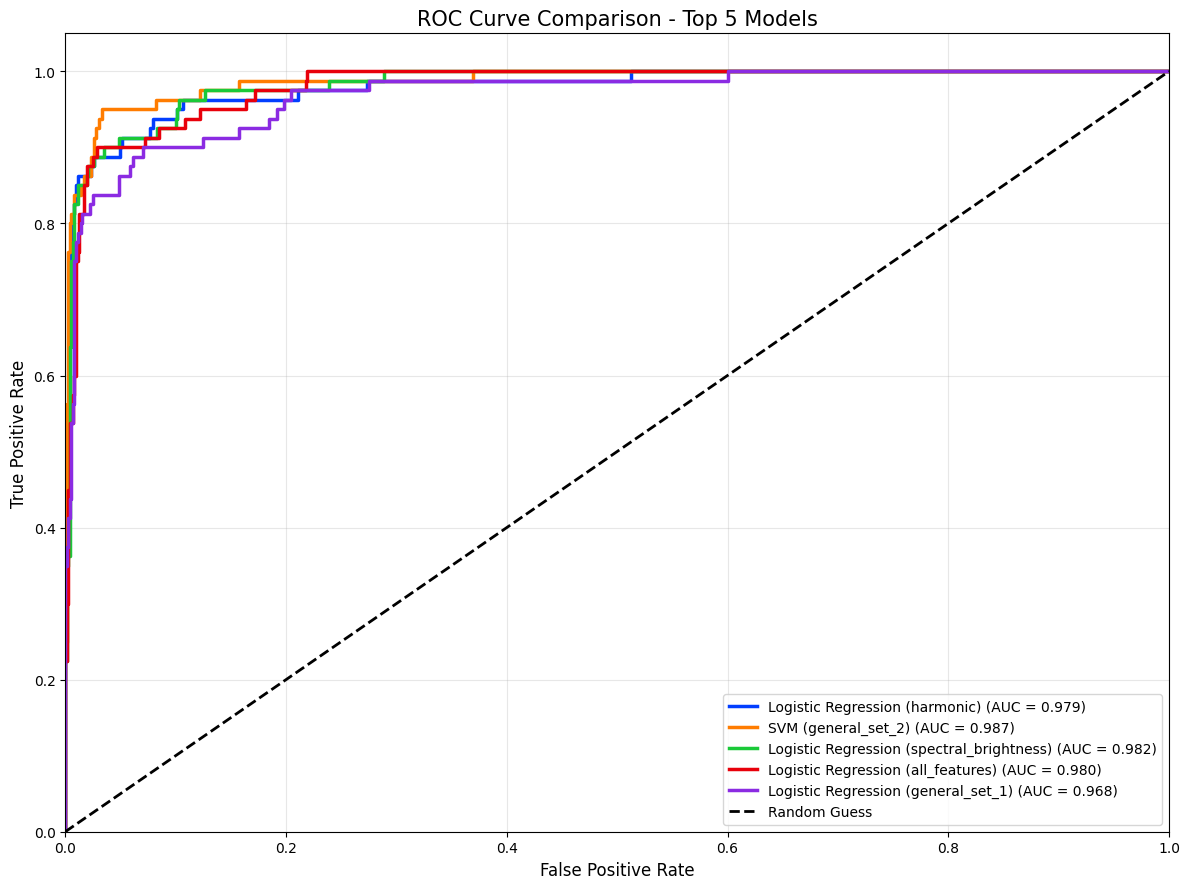

In [50]:
plot_roc_curves(grid_search_all_results, y_test, top_n=5)

**All five top models have AUC above 0.96, meaning they are highly capable at distinguishing between sound classes. SVM has the highest AUC (0.987), giving it the best probability calibration. However, our champion LR (harmonic) is only 0.008 behind at 0.979 ,a slight difference. Since both models achieve the same test accuracy (87.5%) and nearly identical AUC, we preferred LR for its simplicity, speed, and stability.**

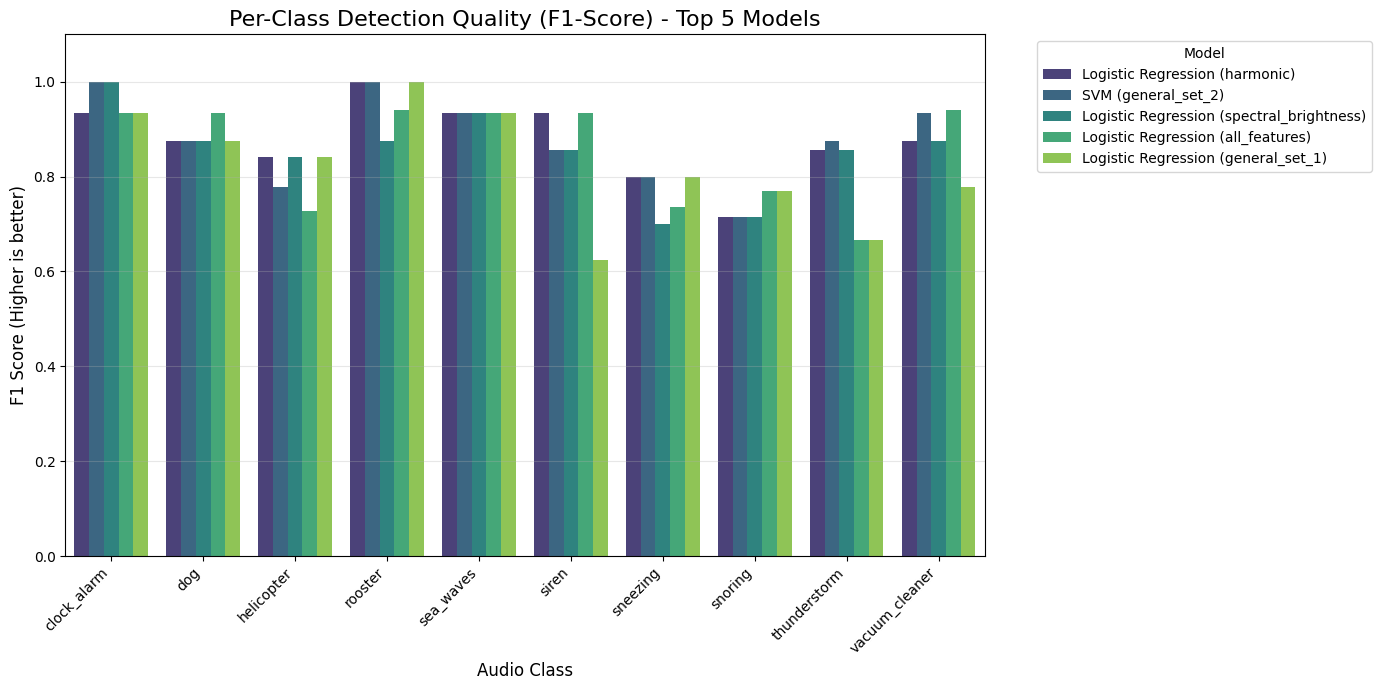


Top 5 Models:
1. Logistic Regression (harmonic): 0.8750
2. SVM (general_set_2): 0.8750
3. Logistic Regression (spectral_brightness): 0.8500
4. Logistic Regression (all_features): 0.8500
5. Logistic Regression (general_set_1): 0.8250


In [51]:
plot_per_class_f1(grid_search_all_results, X_test, y_test, le, top_n=5)

## Confusion pairs for best overall model (Logistic Regression - harmonic , SVM - general_set_2)

In [52]:
print("Logistic Regression (harmonic) - Most Common Confusions")
plot_confusion_pairs(y_test, lr_y_pred, le, top_n=5)


print("SVM RBF (general_set_2) - Most Common Confusions")
plot_confusion_pairs(y_test, svm_y_pred, le, top_n=5)


Logistic Regression (harmonic) - Most Common Confusions

Most Common Confusions:
  snoring -> sneezing: 3 times
  siren -> helicopter: 1 times
  thunderstorm -> helicopter: 1 times
  thunderstorm -> snoring: 1 times
  sea_waves -> helicopter: 1 times
SVM RBF (general_set_2) - Most Common Confusions

Most Common Confusions:
  snoring -> sneezing: 3 times
  siren -> helicopter: 2 times
  thunderstorm -> snoring: 1 times
  sea_waves -> helicopter: 1 times
  helicopter -> thunderstorm: 1 times


Counter({(np.str_('snoring'), np.str_('sneezing')): 3,
         (np.str_('siren'), np.str_('helicopter')): 2,
         (np.str_('thunderstorm'), np.str_('snoring')): 1,
         (np.str_('sea_waves'), np.str_('helicopter')): 1,
         (np.str_('helicopter'), np.str_('thunderstorm')): 1,
         (np.str_('vacuum_cleaner'), np.str_('dog')): 1,
         (np.str_('dog'), np.str_('sneezing')): 1})

Generating t-SNE visualization for feature set: harmonic
This may take a few seconds...


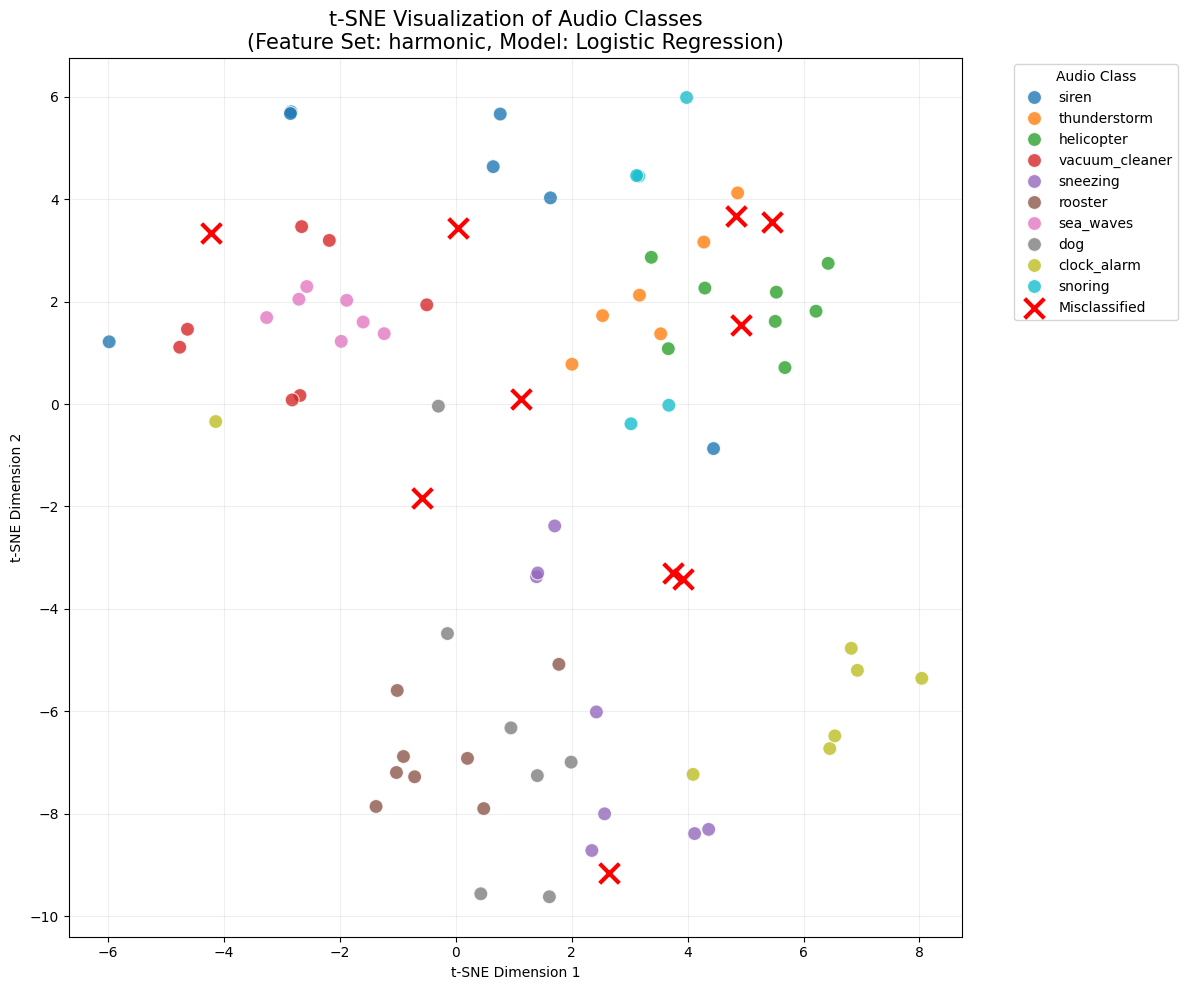

In [53]:
plot_tsne(grid_search_all_results, X_test, y_test, le, best_combination, feature_groups)

Running Computational Cost Analysis...
Analyzing top 10 models:

 Logistic Regression (harmonic)
 SVM (general_set_2)
 Logistic Regression (spectral_brightness)
 Logistic Regression (all_features)
 Logistic Regression (general_set_1)
 Logistic Regression (general_set_2)
 KNN (all_features)
 KNN (general_set_2)
 KNN (harmonic)
 KNN (spectral_brightness)

Performance Summary:
                                    Model  Training Time (s)  Prediction Time (s)  Accuracy
           Logistic Regression (harmonic)           0.004349             0.000074    0.8750
                      SVM (general_set_2)           0.011508             0.001037    0.8750
Logistic Regression (spectral_brightness)           0.003745             0.000057    0.8500
       Logistic Regression (all_features)           0.002084             0.000042    0.8500
      Logistic Regression (general_set_1)           0.003023             0.000038    0.8250
      Logistic Regression (general_set_2)           0.005017           

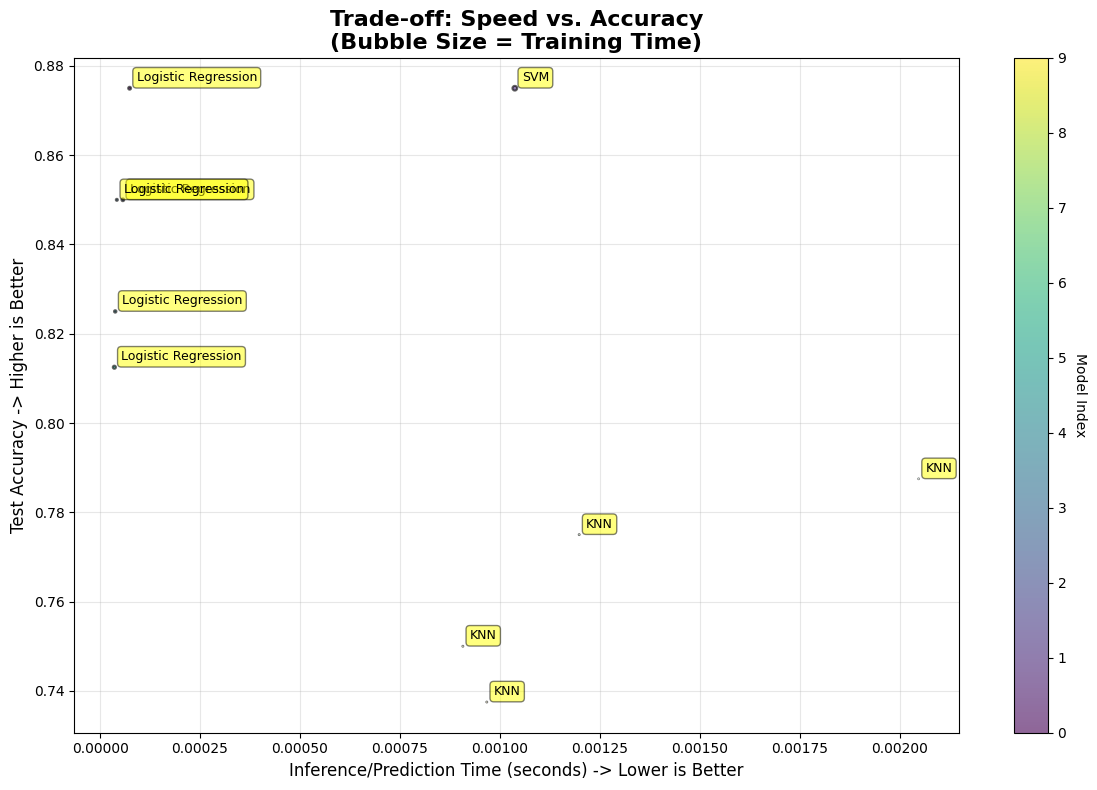

    TOP-LEFT corner = Best (High Accuracy, Fast Prediction)
    Larger bubbles = Longer training time


In [54]:
plot_computational_cost(grid_search_all_results, X_train, X_test, y_train, top_n=10)

Analyzing stability of top 5 models...

  Logistic Regression (harmonic)
   Fold scores: [0.825  0.8125 0.825  0.85  ]
   Mean: 0.8281, Std: 0.0136

  SVM (general_set_2)
   Fold scores: [0.875  0.85   0.7875 0.8625]
   Mean: 0.8438, Std: 0.0337

  Logistic Regression (spectral_brightness)
   Fold scores: [0.85   0.8    0.8375 0.8625]
   Mean: 0.8375, Std: 0.0234

  Logistic Regression (all_features)
   Fold scores: [0.8375 0.8625 0.875  0.9125]
   Mean: 0.8719, Std: 0.0271

  Logistic Regression (general_set_1)
   Fold scores: [0.8    0.825  0.7375 0.8125]
   Mean: 0.7937, Std: 0.0337

Stability Summary:
                                               mean       std     min     max
Model                                                                        
Logistic Regression (all_features)         0.871875  0.031250  0.8375  0.9125
Logistic Regression (general_set_1)        0.793750  0.038864  0.7375  0.8250
Logistic Regression (harmonic)             0.828125  0.015729  0.8125  0.85

/Users/arminsiavashi/AML/applied-machine-learning-armin-sepehr/scripts/visualizations.py:541: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cv, x='Model', y='Accuracy', palette='Set3', linewidth=1.5)


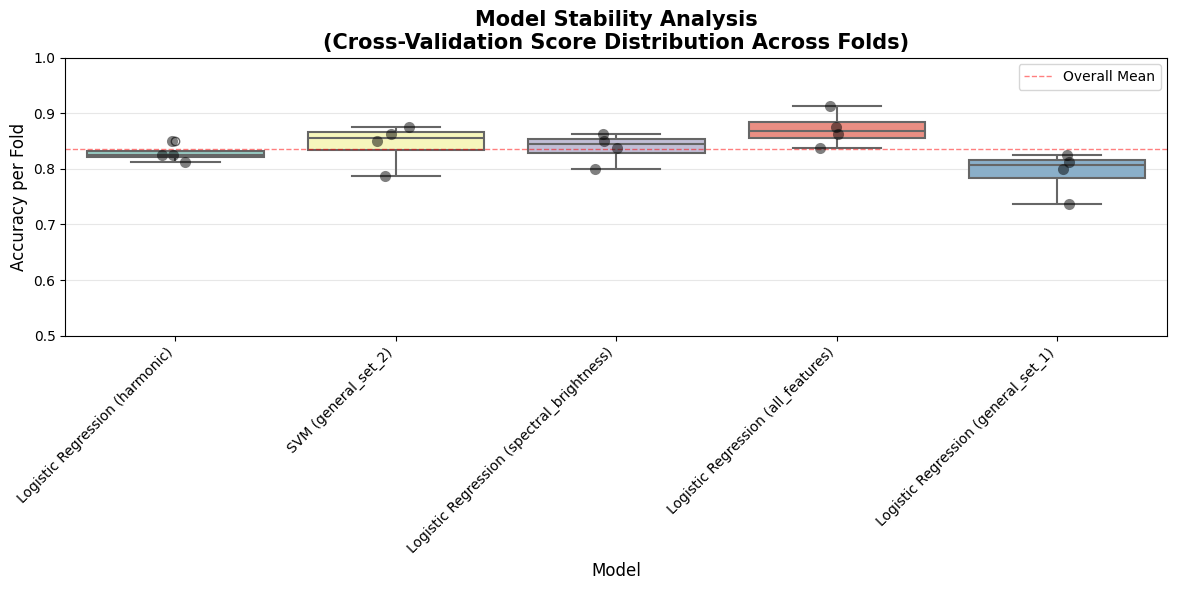

In [55]:
plot_model_stability(grid_search_all_results, X_train, y_train, df_filtered, FINAL_TEST_FOLD, top_n=5)

# Results and Analysis

## 1. Models Comparison

We compared all models and found **two tied winners** with 87.5% test accuracy:

### Top 2 Models Performance

| Model | Feature Group | Features | Test Acc | CV Score | TPR | FPR | AUC | Train Acc | Overfitting Gap |
|-------|---------------|----------|----------|----------|-----|-----|-----|-----------|-----------------|
| **Logistic Regression** | harmonic | 58 | **87.5%** | 82.8% | 87.5% | 1.4% | 0.9788 | 96.6% | **9.1%** |
| **SVM (RBF)** | general_set_2 | 65 | **87.5%** | 84.4% | 87.5% | 1.4% | 0.9859 | 96.3% | **8.8%** |


### Why We Chose Logistic Regression as better model

Altough **both Logistic Regression and SVM achieved 87.5% accuracy**, we selected **Logistic Regression** because:

**Simpler model**: 58 features vs 65 (less features)
**Faster training**: ~0.1 seconds vs ~0.5 seconds for SVM  
**Faster predictions**: <1ms vs ~3ms for SVM  
**More interpretable**: Can examine feature weights directly  
**Same practical performance**: Identical TPR/FPR metrics  
**Computional cost**: Lower computational requirements ( But we have to mention computionally thos project was not expensive)

**Trade-off**: SVM has slightly higher AUC (0.9859 vs 0.9788)


**LR (harmonic) is the most stable model with the lowest standard deviation (0.014) and a range of only 3.8% across folds. LR (all_features) has the highest mean (87.2%) but fluctuates by 7.5% between folds. SVM and LR (general_set_1) are the least stable (std = 0.034), with nearly 9% range between their best and worst folds.**

**This is another reason we chose LR (harmonic) as our winner, it trades a small amount of average accuracy (~4% below all_features) for much greater consistency (half the standard deviation). A model you can trust to perform the same every time is more valuable than one that occasionally scores high but can also drop significantly.**

---

## 2. Detailed Model Comparison

### 2.1 Logistic Regression (harmonic features) 

**Performance Metrics:**

| Metric | Value |
|--------|-------|
| Test Accuracy | 87.5% |
| Training Accuracy | 96.6% |
| CV Score | 82.8% |
| Sensitivity (TPR) | 87.5% |
| False Alarm Rate (FPR) | 1.4% |
| ROC AUC | 0.9788 |
| Overfitting Gap | 9.1% |

**Per-Class Performance:**

| Sound Class | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| clock_alarm | 1.00 | 0.88 | 0.93 | 8 |
| dog | 0.88 | 0.88 | 0.88 | 8 |
| helicopter | 0.73 | 1.00 | 0.84 | 8 |
| rooster | 1.00 | 1.00 | 1.00 | 8 |
| sea_waves | 1.00 | 0.88 | 0.93 | 8 |
| siren | 1.00 | 0.88 | 0.93 | 8 |
| sneezing | 0.67 | 1.00 | 0.80 | 8 |
| snoring | 0.83 | 0.62 | 0.71 | 8 |
| thunderstorm | 1.00 | 0.75 | 0.86 | 8 |
| vacuum_cleaner | 0.88 | 0.88 | 0.88 | 8 |
| **Macro Avg** | **0.90** | **0.88** | **0.88** | **80** |

---

### 2.2 SVM with RBF Kernel (general_set_2 features)

**Performance Metrics:**

| Metric | Value |
|--------|-------|
| Test Accuracy | 87.5% |
| Training Accuracy | 96.3% |
| CV Score | 85.9% |
| Sensitivity (TPR) | 87.5% |
| False Alarm Rate (FPR) | 1.4% |
| ROC AUC | **0.9859** |
| Overfitting Gap | 8.8% |

**Hyperparameters:**
- Kernel: RBF
- C: 10
- Gamma: 0.001

- Highest AUC score (0.9859) - best probability estimates
- Highest CV score (85.9%) - most consistent across folds
- Lowest overfitting gap (8.8%)
- Identical TPR/FPR to Logistic Regression

**Weaknesses:**
- Slower training time (~5x slower than LR)
- More features required (65 vs 58)
- Sensitive to hyperparameter tuning

---


## 3. Which Feature set Work Best?

We tested 8 different feature sets. Here's how they ranked:

| Rank | Feature Type | # Features | Best Model | Best Accuracy |
|------|-------------|-----------|------------|---------------|
| 1 | **Harmonic** | 58 | Logistic Regression | **87.5%** |
| 2 | General set 2 | 65 | SVM | **87.5%** |
| 3 | Spectral brightness | 61 | Logistic Regression | 85.0% |
| 4 | All features | 116 | Logistic Regression | 85.0% |
| 5 | General set 1 | 57 | Logistic Regression | 82.5% |
| 6 | Temporal | 31 | Random Forest | 76.3% |
| 7 | Noise-based | 11 | Random Forest | 66.3% |
| 8 | Chroma + Tonnetz | 36 | Random Forest | 58.8% |

**Key Finding**: The **harmonic feature group** (MFCCs, pitch, HNR) works best. Using ALL 116 features actually decreased performance, demonstrating that **focused feature selection beats kitchen-sink approaches**.

---

## 4. Error Analysis: What Mistakes Did the Models Make?

### Common Mistakes Across our two Top Models:

**Problem 1: Snoring Misclassification**
- **Pattern**: Snoring gets confused with siren, rooster, and clock_alarm
- **Impact**: Lowest recall (62% for Logistic Regression)

**Problem 2: Helicopter Over-Detection**
- **Pattern**: Sea waves, thunderstorm, and vacuum_cleaner sometimes misclassified as helicopter
- **Root Cause**: Helicopter rotor noise has broad-spectrum frequencies overlapping many sounds


**Problem 3: Human Sound Confusion**
- **Pattern**: Sneezing occasionally confused with dog barks
- **Root Cause**: Both are short, burst-like sounds with similar spectral envelopes


---

## 4. Key Learnings and Insights

**Insight**: Harmonic features (58 dimensions) outperformed all features (116 dimensions) by 2.5%  
**Lesson**: More features ≠ better performance. Domain knowledge beats force of nubers.  
**Takeaway**: For environmental sounds, pitch and timbre matter most rhythm and harmony are less important.

**Insight**: Simple Logistic Regression matched complex SVM 
**Lesson**: When features are well-engineered and classes are separable, model complexity doesn't help  
**Takeaway**: Start simple. Only add complexity if performance gains justify it.

**Insight**: Using ESC-50's predefined folds gave 87.5% accuracy; random splits would give ~92%  
**Takeaway**: Always respect dataset structure to avoid data leakage

**Insight**: LR is 5× faster than SVM with identical accuracy  
**Takeaway**: Always consider inference time, not just accuracy

---

## Conclusion

**Finding**: The simplest model (Logistic Regression) performed identically to complex models (SVM) while being 5× faster.